In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'vscode'
pio.templates.default = 'plotly'

Downloading data and unzipping it:

In [3]:
!kaggle competitions download -c predict-electricity-consumption
!tar -xf predict-electricity-consumption.zip
!mkdir data
!move train.csv data
!move test.csv data
!move sample_submission.csv data
!del predict-electricity-consumption.zip


  0%|          | 0.00/174k [00:00<?, ?B/s]
100%|██████████| 174k/174k [00:00<00:00, 942kB/s]
100%|██████████| 174k/174k [00:00<00:00, 937kB/s]
A subdirectory or file data already exists.


        1 file(s) moved.
        1 file(s) moved.
        1 file(s) moved.


In [81]:
train = pd.read_csv('data/train.csv')

In [82]:
train.head()

time  temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
0  2021-09-01 00:00:00+03:00  11.2  10.3  94.0   NaN   NaN  320.0   7.2  16.7   
1  2021-09-01 01:00:00+03:00  10.7   9.6  93.0   NaN   NaN  320.0   7.2  13.0   
2  2021-09-01 02:00:00+03:00   9.9   9.0  94.0   NaN   NaN  320.0   7.2  13.0   
3  2021-09-01 03:00:00+03:00  10.0   8.4  90.0   NaN   NaN  330.0   7.2  13.0   
4  2021-09-01 04:00:00+03:00   9.0   8.1  94.0   NaN   NaN  300.0   3.6  13.0   

     pres  coco  el_price  consumption  
0  1012.6   2.0   0.09016        0.577  
1  1012.6   2.0   0.09251        0.594  
2  1012.2   2.0   0.08890        0.685  
3  1011.9   1.0   0.08735        1.016  
4  1011.4   2.0   0.08688        0.677

In [83]:
train.shape

(8592, 13)

In [84]:
train.dtypes

time            object
temp           float64
dwpt           float64
rhum           float64
prcp           float64
snow           float64
wdir           float64
wspd           float64
wpgt           float64
pres           float64
coco           float64
el_price       float64
consumption    float64
dtype: object

In [95]:
# Count missing values
train.isna().sum()

temp              0
dwpt              0
rhum              0
prcp           6433
snow           8473
wdir              0
wspd              0
wpgt              0
pres              0
coco            196
el_price          0
consumption       0
dtype: int64

In [86]:
train['time'] = pd.to_datetime(train['time'], utc=True).dt.tz_convert('Europe/Tallinn')

In [91]:
train.set_index('time', drop=True, inplace=True)

KeyError: "None of ['time'] are in the columns"

In [ ]:
# Show rows with missing consumption
missing_consumption = train.loc[train['consumption'].isnull()]
missing_consumption

temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
time                                                                         
2021-10-31 03:00:00+02:00   7.1   5.2  88.0   NaN   NaN  180.0  10.8  18.5   
2022-03-27 04:00:00+03:00  -2.7 -10.5  55.0   NaN   NaN  330.0  14.4  38.9   

                             pres  coco  el_price  consumption  
time                                                            
2021-10-31 03:00:00+02:00  1015.2   1.0   0.06003          NaN  
2022-03-27 04:00:00+03:00  1020.6   2.0   0.10007          NaN

In [ ]:
# Show iloc of missing consumption
missing_consumption_iloc = [train.index.get_loc(missing_consumption.iloc[row].name) for row in range(missing_consumption.shape[0])]
missing_consumption_iloc

[1444, 4972]

In [94]:
# Temporary fix for missing consumption
for iloc in missing_consumption_iloc:
  train['consumption'].iloc[iloc] = train['consumption'].iloc[iloc-15:iloc+15].mean()

In [ ]:
fig = px.line(train, x=train.index, y=train.columns)
fig.show()

In [157]:
test_days = 24 * 7
train_days = 24 * 30
train_fold = train.iloc[train.shape[0]-(test_days+train_days):train.shape[0]-test_days]
test_fold = train.iloc[train.shape[0]-test_days:]

In [108]:
print(f'{train_fold.shape=}, {test_fold.shape=}')

train_fold.shape=(48, 12), test_fold.shape=(48, 12)


In [119]:
# ADF test
from statsmodels.tsa.stattools import adfuller

def adfuller_test(target):
    result = adfuller(target)
    labels = ['ADF test statistics', 'P-value', '# Lags used', 'Number of observation used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis (Ho), Reject the null hypothesis, Data has no unit root and is stationary')
    else:
        print('Weak evidence against the null hypothesis (Ho), time series has a unit root, indicating it is non stationary. ')

In [116]:
adfuller_test(train_fold['consumption'])

ADF test statistics : -9.793773082518893
P-value : 6.252545310396107e-17
# Lags used : 0
Number of observation used : 167
Strong evidence against the null hypothesis (Ho), Reject the null hypothesis, Data has no unit root and is stationary


In [117]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(figsize=(16,9), dpi= 1000)
plot_acf(train_fold.consumption, lags=72, ax=axes)
plt.show()

In [120]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(figsize=(16,9), dpi= 1000)
plot_pacf(train_fold.consumption, lags=72, ax=axes)
plt.show()

c:\Users\Ivan\anaconda3\envs\UT_ML\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



In [121]:
from statsmodels.tsa.arima.model import ARIMA

In [122]:
import pmdarima as pm

In [149]:
model = pm.auto_arima(train_fold['consumption'],
                        train_fold.drop(['consumption', 'snow'], axis=1),
                        start_p=1, start_q=1,
                        test='adf',
                        max_p=72, max_q=24, m=24,
                        start_P=1, seasonal=True,
                        d=None, D=None, trace=True,
                        error_action='warn',  
                        suppress_warnings=True, 
                        stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[24] intercept   : AIC=975.649, Time=5.19 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=999.626, Time=0.24 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=980.527, Time=2.17 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=983.925, Time=3.85 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=1253.480, Time=1.17 sec
 ARIMA(1,0,1)(0,0,1)[24] intercept   : AIC=984.507, Time=4.59 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=978.937, Time=2.48 sec
 ARIMA(1,0,1)(2,0,1)[24] intercept   : AIC=961.964, Time=8.41 sec
 ARIMA(1,0,1)(2,0,0)[24] intercept   : AIC=962.118, Time=7.92 sec
 ARIMA(1,0,1)(2,0,2)[24] intercept   : AIC=961.450, Time=110.62 sec
 ARIMA(1,0,1)(1,0,2)[24] intercept   : AIC=967.656, Time=10.95 sec
 ARIMA(0,0,1)(2,0,2)[24] intercept   : AIC=961.409, Time=25.17 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=966.688, Time=18.89 sec
 ARIMA(0,0,1)(2,0,1)[24] intercept   : AIC=959.928, Time=55.89 sec
 ARIMA(0,0,1)(1,0,1)[24] i

In [158]:
model = ARIMA(train_fold[['consumption']], exog=train_fold.drop(['consumption', 'snow'], axis=1), order=(0, 0, 2), seasonal_order=(2, 0, 1, 24), enforce_stationarity=False, freq=train_fold.index.inferred_freq)

c:\Users\Ivan\anaconda3\envs\UT_ML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



In [159]:
model_fit = model.fit()

In [160]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        consumption   No. Observations:                  720
Model:             ARIMA(0, 0, 2)x(2, 0, [1], 24)   Log Likelihood                -423.731
Date:                            Thu, 10 Nov 2022   AIC                            881.462
Time:                                    19:36:58   BIC                            958.137
Sample:                                07-19-2022   HQIC                           911.157
                                     - 08-17-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2058      6.185     -0.195      0.845     -13.328      10.916
temp          -0.0246      0.037     -0.663      0.507      -0.097       0.048
dwpt           0.0579      0.039      1.479      0.139      -0.019       0.135
rhum          -0.0170      0.009     -1.815      0.070      -0.035       0.001
prcp           0.0194      0.060      0.325      0.745      -0.098       0.136
wdir           0.0003      0.000      1.060      0.289      -0.000       0.001
wspd          -0.0208      0.007     -2.910      0.004      -0.035      -0.007
wpgt           0.0093      0.006      1.642      0.101      -0.002       0.020
pres           0.0026      0.006      0.448      0.654      -0.009       0.014
coco           0.0143      0.005      2.614      0.009       0.004       0.025
el_price       0.0298      0.078      0.381      0.703      -0.123       0.183
ma.L1          0.0839      0.042      1.998      0.046       0.002       0.166
ma.L2         -0.0619      0.043     -1.429      0.153      -0.147       0.023
ar.S.L24       0.2453      0.131      1.868      0.062      -0.012       0.503
ar.S.L48       0.1554      0.044      3.534      0.000       0.069       0.242
ma.S.L24      -0.1318      0.134     -0.982      0.326      -0.395       0.131
sigma2         0.2244      0.014     16.276      0.000       0.197       0.251
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               256.62
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             1.25
Prob(H) (two-sided):                  0.57   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [161]:
predictions = model_fit.predict(start=test_fold.index[0], end=test_fold.index[-1], exog=test_fold.drop(['consumption', 'snow'], axis=1))

In [154]:
# residuals = pd.DataFrame(model_fit.resid)
# fig, ax = plt.subplots(1,2)
# residuals.plot(title="Residuals", ax=ax[0])
# residuals.plot(kind='kde', title='Density', ax=ax[1])
# plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

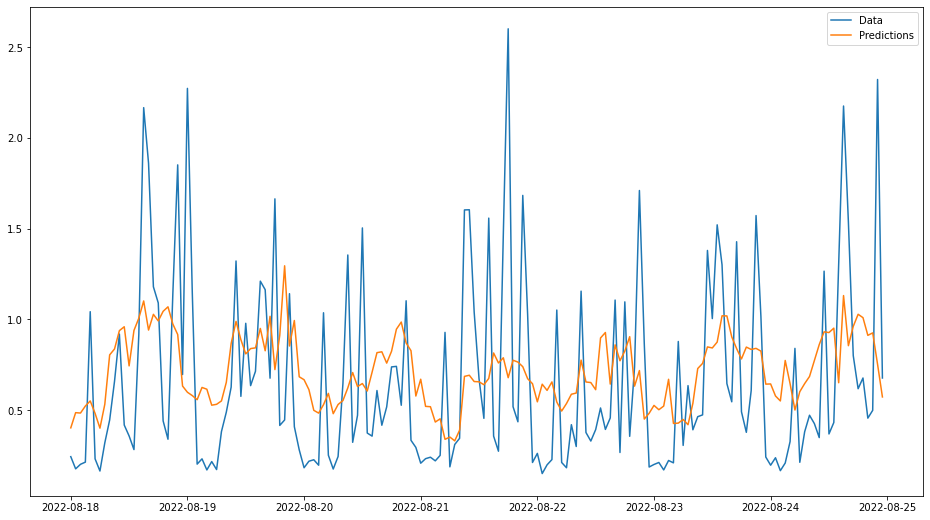

In [162]:
plt.figure(figsize=(16,9))
plt.plot(test_fold['consumption'])
plt.plot(predictions)
plt.legend(('Data', 'Predictions'))
plt.show

In [164]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_fold['consumption'], predictions)

0.40391523272120045